In [1]:
import logging
import time
import random

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.utils as vutils
from torch import cuda

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [4]:
from CGAN import CGAN ##### select CGAN model
from utils import get_data_loader, generate_images, save_gif
import LeNet

In [5]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [6]:
#hyperparameter settings
args = type('test', (object,), {})()
args.num_epochs = 5 #####10
args.ngpu = 1
args.ndf = 128
args.ngf = 128
args.nz = 100
args.lr = 0.0002
args.beta = 0.5
args.nc = 1
args.batch_size = 60 #####64
args.image_size = 32
args.num_test_samples = 64
args.output_path = "./results/"
args.fps = 5
args.use_fixed = True
args.plot = True

In [7]:
# Gather MNIST Dataset
transform=transforms.Compose([
                           transforms.Resize(args.image_size),
                           transforms.CenterCrop(args.image_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=0.5, std=0.5)
                        #    transforms.Normalize(mean=(0.1307, ), std=(0.3081, )),
                       ])    
dataset = dset.MNIST(root='./mnist_data/',
                       transform=transform, download=True)

In [8]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,
                                     shuffle=True)


In [9]:
# Device configuration
device = torch.device('cuda:0' if (torch.cuda.is_available() and args.ngpu > 0) else 'cpu')
print("Using", cuda.get_device_name(0))

Using NVIDIA GeForce RTX 3070


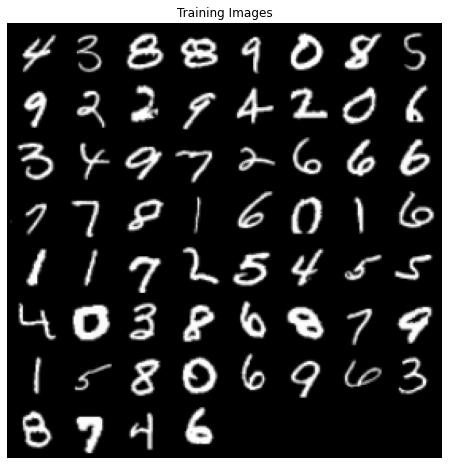

In [10]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
cgan = CGAN(ngpu=args.ngpu, device=device, lr=args.lr, nc=args.nc, ndf=args.ndf, nz=args.nz, ngf=args.ngf, beta1=args.beta, real_label=0.9)

In [12]:
# initialize other variables
num_batches = len(dataloader)
fixed_noise = torch.randn(args.num_test_samples, args.nz, 1, 1, device=device)

Starting Training Loop...
[0/5][0/1000]	Loss_D: 1.3389	Loss_G: 2.5589	D(x): 0.5162	D(G(z)): 0.4778 / 0.2622
[0/5][50/1000]	Loss_D: 0.0501	Loss_G: 6.2760	D(x): 0.9695	D(G(z)): 0.0178 / 0.0169
[0/5][100/1000]	Loss_D: 0.0045	Loss_G: 8.7612	D(x): 0.9985	D(G(z)): 0.0030 / 0.0025
[0/5][150/1000]	Loss_D: 0.0007	Loss_G: 11.8111	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[0/5][200/1000]	Loss_D: 0.0012	Loss_G: 9.7737	D(x): 0.9998	D(G(z)): 0.0010 / 0.0009
[0/5][250/1000]	Loss_D: 0.0016	Loss_G: 9.2527	D(x): 0.9996	D(G(z)): 0.0012 / 0.0009
[0/5][300/1000]	Loss_D: 0.0006	Loss_G: 9.6014	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003
[0/5][350/1000]	Loss_D: 0.0005	Loss_G: 9.8655	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002
[0/5][400/1000]	Loss_D: 0.0004	Loss_G: 11.2415	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][450/1000]	Loss_D: 0.0002	Loss_G: 10.9401	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[0/5][500/1000]	Loss_D: 0.0001	Loss_G: 13.0180	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][550/1000]	Loss_D: 0.0001	Loss_G: 12.6825	D(

[4/5][850/1000]	Loss_D: 0.0001	Loss_G: 12.8296	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[4/5][900/1000]	Loss_D: 0.0001	Loss_G: 11.9815	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[4/5][950/1000]	Loss_D: 0.0003	Loss_G: 13.0775	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


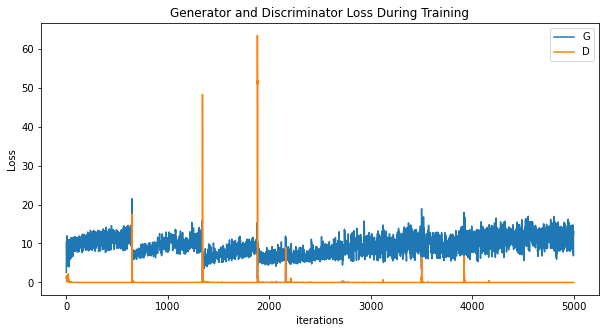

In [13]:
img_list = cgan.train(dataloader=dataloader, num_epochs=args.num_epochs, plot=args.plot)

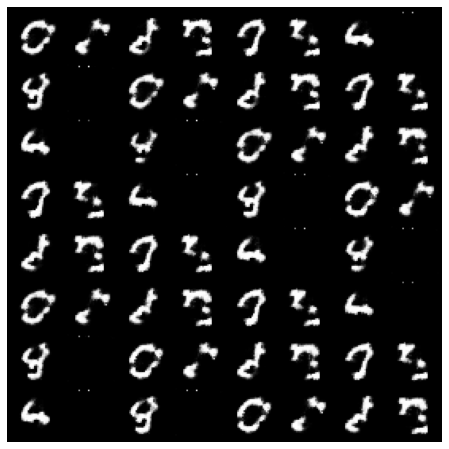

In [14]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
writergif = animation.PillowWriter(fps=30) 
ani.save(args.output_path+"fake_cgan.gif", writer=writergif)

In [15]:
#save model
model_path = "./models/"
filename = "cgan_Q2_smoothing_vbn.pt"
torch.save(cgan, model_path+filename)

In [13]:
#load model
model_path = "./models/"
filename = "cgan_Q2_smoothing.pt"
cgan = torch.load(model_path+filename)

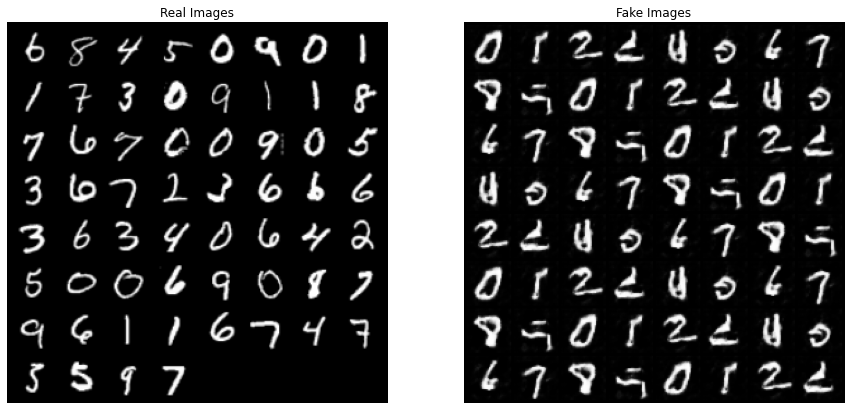

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [17]:
classifier = LeNet.Classifier(device)

In [18]:
#train classifier
model_path = "./models/"
filename = "lenet_Q2.pt"
classifier.train(num_epochs=10, model_path=model_path, filename=filename)

EPOCH 0 ...
Validation Accuracy = 0.965

EPOCH 1 ...
Validation Accuracy = 0.978

EPOCH 2 ...
Validation Accuracy = 0.988

EPOCH 3 ...
Validation Accuracy = 0.987

EPOCH 4 ...
Validation Accuracy = 0.988

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.988

EPOCH 7 ...
Validation Accuracy = 0.987

EPOCH 8 ...
Validation Accuracy = 0.986

EPOCH 9 ...
Validation Accuracy = 0.988

Test Accuracy = 0.986
Model saved


In [20]:
#load lenet classifier
model_path = "./models/"
filename = "lenet_Q2.pt"
classifier.load(model_path, filename)

Model loaded


In [19]:
#create fake dataset and dataloader
fake_dataset, fake_dataloader = cgan.create_dataloader(num_samples=1000, batch_size=128)

In [20]:
#evaluate on fake data
accuracy, predicts = classifier.evaluate(fake_dataloader, fake_dataset)

In [21]:
print(accuracy)

0.7
